/Users/florian_wuennemann/miniconda3/envs/spatialomics_MI/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/ph/m6mhj3s541799cykzbp3dx0m0000gn/T/ipykernel_81650/4242772205.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get

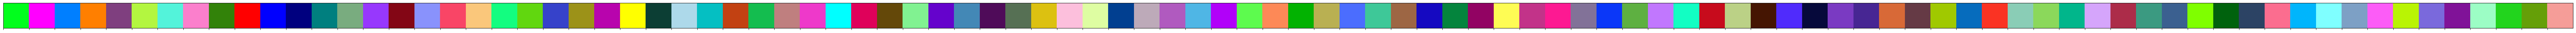

In [1]:
# just installing napari, geopandas and tifffile should be enough to import everything
import pandas as pd
import napari
import skimage.io
import geopandas as gp
from shapely.geometry import Polygon
import distinctipy
import seaborn as sns
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import sys
from skimage.segmentation import find_boundaries
sys.path.append("../")
from spatialMI_functions import plot_layers_napari, crop_black_margins, add_scalebar, crop_coords

# Get a list of distinct colors
colors = distinctipy.get_colors(100)
sns.palplot(colors)

In [2]:
sample = "sample_control_r1_s1"
colors = ["#fc6b09","#0090ad","#cadb2b","#cb2027","#029e88", "#e18d9a"]

# napari_screenshot = '../../output/molkart/molkart_figure1_images/'+sample+'.napari_screen.full_image.png'
# roi = pd.read_csv("../../data/molkart_tissue_regions_rois/"+sample+".figure_1_roi.csv")

## image
img_dir = "../../../results/nf-core_molkart/stack/"
img_stack=  skimage.io.imread(img_dir+sample+"_stack.ome.tif")
xmax, ymax = img_stack[[0]].shape[2], img_stack[[1]].shape[1]


## ROI for zoom in
# Read in roi as geojson file
roi = gp.read_file("../../annotations/molkart/Supplementary_Figure4_regions/geojson/sample_control_r1_s1.region.geojson")
# Convert to shapely polygon
roi = Polygon(roi.geometry[0])
# Get coordinates of polygon
roi = np.array(roi.exterior.coords.xy)
# Convert the roi into an array of shape 4,2 (4 corners, 2 coordinates)
roi = np.array([roi[1], roi[0]]).T
# Take only the first 4 elements of the array
roi = roi[[0,3,2,1],:]

## Output
outdir = "../../output/molkart/supplementary_figure_4_images/"

scale_var = 3

# Generate images for Supplementary figure 4

## DAPI + WGA

### Whole slide DAPI + WGA

In [4]:
## Generate 
viewer = napari.view_image(img_stack, channel_axis = 0,
                           name=["nuclei", "membrane"],
                           colormap=["cyan", "magenta"],
                           contrast_limits=[[1000, 65535], [1000, 65535]],)

# viewer.add_labels(mask)

viewer.add_shapes(roi, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)
full_screenshot = outdir+sample+".dapi_wga.full_image.wborder.png"
viewer.screenshot(path=full_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".dapi_wga.full_image.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

31-Jan-24 11:58:42 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [9]:
## Calculate scale factors to plot a scalebar
img = Image.open(crop_screenshot)
width = img_stack[[0]].shape[2]
new_resolution = img.size[0] / (width * 0.138)

crop_scalebar = outdir+sample+".dapi_wga.full_image.clean.wbar.png"
add_scalebar(crop_screenshot,
             scalebar_length_um=500,
             pixel_resolution = new_resolution,
             corner="bottom right", image_with_scalebar_path=crop_scalebar, font_size=200)

'../../output/molkart/supplementary_figure_4_images/sample_control_r1_s1.dapi_wga.full_image.clean.wbar.png'

### Zoom-in DAPI + WGA

In [11]:
# Subset img_stack using roi coordinates. Remember that img_stack has the shape (C,Y,X) with C = 2
img_stack_roi = img_stack[:, int(roi[0,0]):int(roi[2,0]), int(roi[0,1]):int(roi[2,1])]

viewer = napari.view_image(img_stack_roi, channel_axis = 0,
                           name=["nuclei", "membrane"],
                           colormap=["cyan", "magenta"],
                           contrast_limits=[[1000, 65535], [1000, 65535]],)

# viewer.add_labels(mask)

full_screenshot = outdir+sample+".dapi_wga.zoom_image.wborder.png"
viewer.screenshot(path=full_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".dapi_wga.zoom_image.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

In [14]:
## Calculate scale factors to plot a scalebar
img = Image.open(crop_screenshot)
width = roi[2,1] - roi[0,1]
new_resolution = img.size[0] / (width * 0.138)

crop_scalebar = outdir+sample+".dapi_wga.zoom_image.clean.wbar.png"
add_scalebar(crop_screenshot,
             scalebar_length_um=50,
             pixel_resolution = new_resolution,
             corner="bottom right", image_with_scalebar_path=crop_scalebar, font_size=200)

'../../output/molkart/supplementary_figure_4_images/sample_control_r1_s1.dapi_wga.zoom_image.clean.wbar.png'

## Masks

### Mesmer

In [39]:
## segmentation mask
img_dir = "../../../results/nf-core_molkart/filtered_masks/mesmer/"
mask = skimage.io.imread(img_dir+sample+"_mesmer_filtered.tif")

viewer = napari.Viewer()
viewer.add_labels(mask, opacity = 1)
viewer.add_shapes(roi, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)

full_screenshot = outdir+sample+".mask.full.wborder.png"
viewer.screenshot(path=full_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".mask.full.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

In [30]:
# Subset mask using roi coordinates. Mask has the shape (Y,X)
mask_crop = mask[int(roi[0,0]):int(roi[2,0]), int(roi[0,1]):int(roi[2,1])]

viewer = napari.Viewer()
viewer.add_labels(mask_crop, opacity = 1)

roi_screenshot = outdir+sample+".mask.roi.wborder.png"
viewer.screenshot(path=roi_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".mask.roi.clean.png"
crop_black_margins(roi_screenshot, crop_screenshot)

### Ilastik

In [40]:
## segmentation mask
img_dir = "../../../results/nf-core_molkart/filtered_masks/ilastik/"
mask = skimage.io.imread(img_dir+sample+"_ilastik_filtered.tif")

viewer = napari.Viewer()
viewer.add_labels(mask, opacity = 1)
viewer.add_shapes(roi, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)

full_screenshot = outdir+sample+".mask_ilastik.full.wborder.png"
viewer.screenshot(path=full_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".mask_ilastik.full.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

In [35]:
# Subset mask using roi coordinates. Mask has the shape (Y,X)
mask_crop = mask[int(roi[0,0]):int(roi[2,0]), int(roi[0,1]):int(roi[2,1])]

viewer = napari.Viewer()
viewer.add_labels(mask_crop, opacity = 1)

roi_screenshot = outdir+sample+".mask_ilastik.roi.wborder.png"
viewer.screenshot(path=roi_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".mask_ilastik.roi.clean.png"
crop_black_margins(roi_screenshot, crop_screenshot)

### Cellpose

In [41]:
## segmentation mask
img_dir = "../../../results/nf-core_molkart/filtered_masks/"
mask = skimage.io.imread(img_dir+sample+"_cellpose_filtered.tif")

viewer = napari.Viewer()
viewer.add_labels(mask, opacity = 1)
viewer.add_shapes(roi, shape_type=['polygon'],
                  edge_color='white', edge_width=40, face_color="transparent", opacity=1)

full_screenshot = outdir+sample+".mask_cellpose.full.wborder.png"
viewer.screenshot(path=full_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".mask_cellpose.full.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

In [37]:
# Subset mask using roi coordinates. Mask has the shape (Y,X)
mask_crop = mask[int(roi[0,0]):int(roi[2,0]), int(roi[0,1]):int(roi[2,1])]

viewer = napari.Viewer()
viewer.add_labels(mask_crop, opacity = 1)

roi_screenshot = outdir+sample+".mask_cellpose.roi.wborder.png"
viewer.screenshot(path=roi_screenshot, scale = scale_var)

crop_screenshot = outdir+sample+".mask_cellpose.roi.clean.png"
crop_black_margins(roi_screenshot, crop_screenshot)